In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn import metrics

In [5]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

---

In [6]:
# active function: sigmoid
def sigmoid(v):
    return 1.0 / (1.0 + np.exp(-v.clip(max=500,min=-500)))

def sigmoid_derivative(v):
    return v * (1 - v)

In [7]:
# active function: ReLU
def relu(v):
    return v.clip(min=0)

def relu_derivative(v):
    return np.where(v>0,1,0)

In [8]:
# model
model = []

In [102]:
# init model
def model_init(input_size, model_define):
    model.clear()
    prev_node_count = input_size
    for node_count, activation_func, activation_derivative in model_define:
        model.append([np.random.randn(prev_node_count, node_count)/np.sqrt(prev_node_count),
                      np.random.randn(node_count)/np.sqrt(prev_node_count),
                      activation_func,
                      activation_derivative])
        prev_node_count = node_count

In [10]:
# batch forward pass, calculate predict value with current model
def model_forward(states):
    cur_res = states
    hidden_layer_input_buf = []
    for layer_weight, inter_weight, activation_func, _ in model:
        hidden_layer_input_buf.append(cur_res)
        cur_res = np.dot(cur_res, layer_weight)
        cur_res += inter_weight
        if activation_func:
            cur_res = activation_func(cur_res)
    return cur_res, hidden_layer_input_buf

In [11]:
# back propagation to update model
def back_propagation(td_err, hidden_layer_input_buf):
    grads = []
    delta = np.atleast_2d(td_err)
    for layer_out, (layer_weight, inter_weight, _, activation_derivative) \
        in zip(reversed(hidden_layer_input_buf), reversed(model)):
        grads.append((np.dot(np.atleast_2d(layer_out).T, delta)/delta.shape[0],
                      delta.mean(axis=0)))
        delta = np.dot(delta, layer_weight.T)
        if activation_derivative:
            delta = delta * activation_derivative(layer_out)
    grads.reverse()
    return grads

In [12]:
# update model with gradients
def update_model(grads):
    for i in range(len(model)):
        model[i][0] = model[i][0] + learning_rate * grads[i][0]
        model[i][1] = model[i][1] + learning_rate * grads[i][1]

---

In [13]:
import sklearn.datasets

In [14]:
test_data = sklearn.datasets.load_breast_cancer(return_X_y=False)

In [15]:
test_data_x_org = test_data['data']
test_data_y_org = test_data['target']

In [16]:
test_data_x_org.shape

(569, 30)

In [17]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [103]:
model_define = [
    (20, sigmoid, sigmoid_derivative),
    (10, sigmoid, sigmoid_derivative),
    (1, sigmoid, sigmoid_derivative),
]

In [104]:
test_data_x = test_data_std[:500]
test_data_y = test_data_y_org[:500]

In [105]:
learning_rate = 0.1

In [106]:
rounds = 200

In [107]:
batch_size = 1

In [108]:
model_init(test_data_x.shape[1], model_define)

In [109]:
%%time
all_cost = []
all_cost_ce = []
for _ in range(rounds):
    cost = 0
    cost_ce = 0
    learning_idx = np.arange(len(test_data_x))
    np.random.shuffle(learning_idx)
    
    for start_idx in range(0, len(test_data_x), batch_size):
#         data_idx = learning_idx[start_idx : min(start_idx+batch_size,len(test_data_x))]
        data_idx = learning_idx[start_idx]
        sample, target = test_data_x[data_idx], test_data_y[data_idx,None]
        predict, hid = model_forward(sample)
        err = target - predict
        grads = back_propagation(err, hid)
        update_model(grads)
        cost += (err*err).sum()
        cost_ce -= (target*np.log(predict)+(1-target)*np.log(1-predict)).sum()
    all_cost.append(cost)
    all_cost_ce.append(cost_ce)

Wall time: 20.1 s


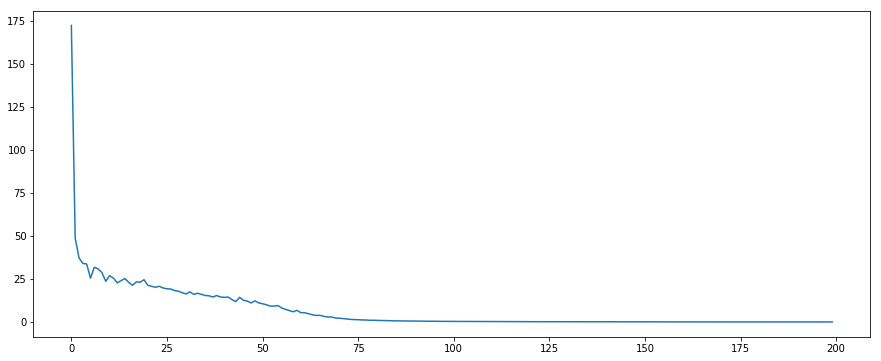

In [110]:
plt.figure(figsize=(15,6))
plt.plot(all_cost_ce)

In [111]:
predict_data_x = test_data_std[500:]
predict_data_y = test_data_y_org[500:]

In [112]:
predict_y = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct, _ = model_forward(sample)
    predict_y.append(pct)

In [113]:
metrics.confusion_matrix(predict_data_y, [1 if pct > 0.5 else 0 for pct in predict_y])

array([[17,  0],
       [ 1, 51]], dtype=int64)

In [114]:
all_cost[-1]

0.0004769938492753988

In [115]:
all_cost_ce[-1]

0.10472751518255773

---

ob

In [45]:
# init model
def test_model_init(input_size, model_define):
    model.clear()
    prev_node_count = input_size
    for node_count, activation_func, activation_derivative in model_define:
#         model.append([np.random.randn(prev_node_count, node_count)/np.sqrt(prev_node_count),
#                       np.random.randn(node_count)/np.sqrt(prev_node_count),
#                       activation_func,
#                       activation_derivative])
        model.append([np.zeros((prev_node_count, node_count))+0.2,
                      np.zeros(node_count)+0.2,
                      activation_func,
                      activation_derivative])
        prev_node_count = node_count

In [46]:
test_model_init(test_data_x.shape[1], model_define)

In [47]:
sample, target = test_data_x[0], test_data_y[0]

In [48]:
predict, hid = model_forward(sample)

In [49]:
predict

array([0.89756353])

In [50]:
hid

[array([ 1.09706398, -2.07333501,  1.26993369,  0.9843749 ,  1.56846633,
         3.28351467,  2.65287398,  2.53247522,  2.21751501,  2.25574689,
         2.48973393, -0.56526506,  2.83303087,  2.48757756, -0.21400165,
         1.31686157,  0.72402616,  0.66081994,  1.14875667,  0.90708308,
         1.88668963, -1.35929347,  2.30360062,  2.00123749,  1.30768627,
         2.61666502,  2.10952635,  2.29607613,  2.75062224,  1.93701461]),
 array([0.99990724, 0.99990724, 0.99990724, 0.99990724, 0.99990724,
        0.99990724, 0.99990724, 0.99990724, 0.99990724, 0.99990724,
        0.99990724, 0.99990724, 0.99990724, 0.99990724, 0.99990724,
        0.99990724, 0.99990724, 0.99990724, 0.99990724, 0.99990724]),
 array([0.98522057, 0.98522057, 0.98522057, 0.98522057, 0.98522057,
        0.98522057, 0.98522057, 0.98522057, 0.98522057, 0.98522057])]

In [51]:
err = target - predict

In [52]:
grads = back_propagation(err, hid)

In [53]:
grads

[(array([[-5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07, -5.31940558e-07,
          -5.31940558e-07, -5.31940558e-07],
         [ 1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06,  1.00531145e-06,
           1.00531145e-06,  1.00531145e-06],
         [-6.15761019e-07, -6.15761019e-07, -6.15761019e-07,
          -6.15761019e-07, -6.15761019e-07, -6.15761019e-07,
          -6.15761019e-07, -6.15761019e-07, -6.15761019e

In [54]:
update_model(grads)

In [55]:
model

[[array([[0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995,
          0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995,
          0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995,
          0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995],
         [0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 ,
          0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 ,
          0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 ,
          0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 , 0.2000001 ],
         [0.19999994, 0.19999994, 0.19999994, 0.19999994, 0.19999994,
          0.19999994, 0.19999994, 0.19999994, 0.19999994, 0.19999994,
          0.19999994, 0.19999994, 0.19999994, 0.19999994, 0.19999994,
          0.19999994, 0.19999994, 0.19999994, 0.19999994, 0.19999994],
         [0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995,
          0.19999995, 0.19999995, 0.19999995, 0.19999995, 0.19999995,
          0.19999

---

try

In [31]:
a1 = np.array([1,2,3])
a2 = np.array([[1,2,3],[1,2,3],[1,2,3],[1,2,3]])
b1 = np.array([4,5,6,7])
b2 = np.array([[4,5,6,7],[4,5,6,7],[4,5,6,7],[4,5,6,7]])
c2 = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3]])

In [32]:
np.atleast_2d(a1).T

array([[1],
       [2],
       [3]])

In [33]:
np.atleast_2d(a2).T

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [34]:
np.dot(np.atleast_2d(a1).T, np.atleast_2d(b1))

array([[ 4,  5,  6,  7],
       [ 8, 10, 12, 14],
       [12, 15, 18, 21]])

In [35]:
np.outer(a1,b1)

array([[ 4,  5,  6,  7],
       [ 8, 10, 12, 14],
       [12, 15, 18, 21]])

In [36]:
np.dot(np.atleast_2d(a2).T, np.atleast_2d(b2))

array([[16, 20, 24, 28],
       [32, 40, 48, 56],
       [48, 60, 72, 84]])

In [37]:
np.dot(b1, c2.T)

array([22, 44, 66])

In [38]:
np.dot(b2, c2.T)

array([[22, 44, 66],
       [22, 44, 66],
       [22, 44, 66],
       [22, 44, 66]])

In [39]:
np.atleast_2d(b1).mean(axis=0)

array([4., 5., 6., 7.])